# Solución Evaluación 2024 - Clasificación Meteorológica


-   **Autores:** Alfonso Carabantes Álamo
-   **Fecha:** Octubre 2024

------------------------------------------------------------------------



## Ejercicio 3

### Introducción
El objetivo del ejercicio es realizar una **Clasificación de Imágenes (Multi Categoría)** en la que podamos decir el tipo de imagen que es.
      
La base de datos es un conjunto de imágenes de **Meteorológicas**.

La base de datos la podréis descargar de esta URL:
https://www.dropbox.com/scl/fi/hzlgwcfavzqmhpylkzuw7/weather.zip?rlkey=m440ako3hlavp8b6jyu0skti9&st=mt7bv32e&dl=1

Esta base de datos recoge **1.125 imágenes** de **tiempo meteorológico**, que están clasificados en **4 categoría**. Caracterizan 4 tipos de días en función de la representación (**Nublado, Soleado, Lluvioso y Puesta de Sol**).

Una vez descargada y descomprimida os encontrareis con una carpeta llamada **weather**. Esta carpeta contendrá a su vez tantas **carpetas como categorías** hay de imágenes.
                                                                            
El conjunto de datos se reparte en los **siguientes directorios**:

-**cloudy** (300 imágenes)

-**shine** (253 imágenes)

-**sunrise** (357 imágenes)

-**rain** (215 imágenes)


### Información de versiones e Importación de funciones propias

Presentamos información de las versiones usadas de Python y tensorflow, además definir todas las funciones que luego usamos para no estar escribiendo todo el rato el mismo código.

In [1]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

import tensorflow as tf
print("Tensorflow version")
print(tf.__version__)

Python version
3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:04:44) [MSC v.1940 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=12, micro=4, releaselevel='final', serial=0)
Tensorflow version
2.17.0


In [2]:
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import applications
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sn
import pandas as pd

### Carga del dataset

In [3]:

# Función para descargar el dataset y descomprimirlo
def carga_dataset():
    global train_dir
    global test_dir
    import pathlib
    dataset_url = "https://www.dropbox.com/scl/fi/hzlgwcfavzqmhpylkzuw7/weather.zip?rlkey=m440ako3hlavp8b6jyu0skti9&st=mt7bv32e&dl=1"
    # Descargamos el fichero con todas las imágenes y 
    # lo desempaquetamos
    global data_dir
    data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   extract=True)

    data_dir = os.path.dirname(data_dir)

    # Definimos los directorios para usar
    data_dir = data_dir + "\\weather"
    print(data_dir)


Cargamos el dataset con la función que hemos definido. Además se desempaquetarán los ficheros teniendo la carpeta **weather** con las 4 subcarpetas para cada una de las categorías: **cloudy**, **rain**, **shine** y **sunrise**.

In [4]:
carga_dataset()

C:\Users\acca3\.keras\datasets\weather


Definimos el parámetro del **batch** que nos dará cuantas imágenes se procesaran en bloque, así como cual será el **tamaño** (alto y ancho) de las imágenes con el que vamos a trabajar.

In [5]:
# Definimos el tamaño del batch
# Definimos el tamaño de imagen con la que queremos trabajar
batch_size = 256
img_height = 150
img_width = 150

### Creación los generadores de imágenes (Split de los datos)

El siguiente paso consiste en preparar los generadores de imágenes que van a leer los ficheros de imágenes desde los directorios, y se los pasarán a nuestro función de entrenamiento.

Usaremos la función `tf.keras.utils.image_dataset_from_directory` que nos permitirá realizar también el **split** entre datos de **entrenamiento** y **validación** (test).
Además podremos definir con que tamaño de imagen se va a trabajar (referenciando a nuestras variables), el **tipo de categorías** (label_model) que afectará posteriormente al tipo de **función de périda** que se vaya a usar.
En este caso usaremos el valor por defecto **int** lo que hace usar un valor entero para cada categoría y hace que tengamos que usar la función `sparse_categorical_crossentropy`. En caso de elegir **categorical**, se produce una codificación **one-hot** y se usaría `categorical_crossentropy`

Con **subset** especificamos si nos da los datos de **entrenamiento** (training) o los de **validación** (validation), además especificamos el porcentaje de reparto con **validation_split**.

Hay que tener mucho cuidado con los datos de **test** si luego vamos a hacer predicciones y queremos comparar con su etiquetado real (construir la matriz de confusión, por ejemplo), ya que por defecto la función `image_dataset_from_directory` tiene un parámetro llamado **Shuffle** que está con valor **True**. Esto significa que cada vez que usamos el objeto, barajea los datos y los presenta en distinto orden. Con lo cual, si nosotros usado el objeto para hacer predicciones y luego lo volvemos a usar para consultar las etiquetas, lo que harán será devolvernos las etiquetas que no corresponden con las imágenes.


In [6]:
# Creamos los generadores de imágenes
# Nos van a permitir leer la imágenes desde los directorios
def crea_generadores_imagenes():
    global train_ds
    global val_ds
    global class_names
    global num_classes
    global ficheros_train_pizza
    global ficheros_train_not_pizza
    global ficheros_test_pizza
    global ficheros_test_not_pizza

    train_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    # Definimos 
    val_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    class_names = train_ds.class_names
    print(class_names)

 
    num_classes = 4

In [7]:
crea_generadores_imagenes()

Found 1125 files belonging to 4 classes.
Using 900 files for training.
Found 1125 files belonging to 4 classes.
Using 225 files for validation.
['cloudy', 'rain', 'shine', 'sunrise']


### Visualización de 5 imágenes de cada categoría

Ahora pasamos a visualizar 5 imágenes por cada categoría. Para ello preparamos una función.

In [8]:
# Función para visualizar imágenes aleatorias (5 de cada clase) de entrenamiento
def visualiza_imagenes():

    # Mostramos los elementos de la clase 0 ( cloudy )
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.map(lambda x, y:  (x[y==0], y[y==0])): # Nos quedamos sólo con los datos de la clase 0
      for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("cloudy")
        plt.axis("off")
          
    # Mostramos los elementos de la clase 1 ( rain )
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.map(lambda x, y:  (x[y==1], y[y==1])):  # Nos quedamos sólo con los datos de la clase 1
      for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("rain")
        plt.axis("off")

    # Mostramos los elementos de la clase 2 ( shine )
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.map(lambda x, y:  (x[y==2], y[y==2])): # Nos quedamos sólo con los datos de la clase 2
      for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("shine")
        plt.axis("off")
          
    # Mostramos los elementos de la clase 3 ( sunrise )
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.map(lambda x, y:  (x[y==3], y[y==3])):  # Nos quedamos sólo con los datos de la clase 3
      for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("sunrise")
        plt.axis("off")


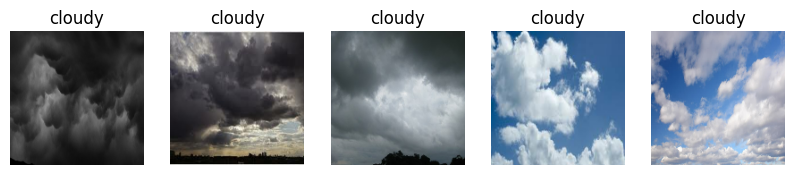

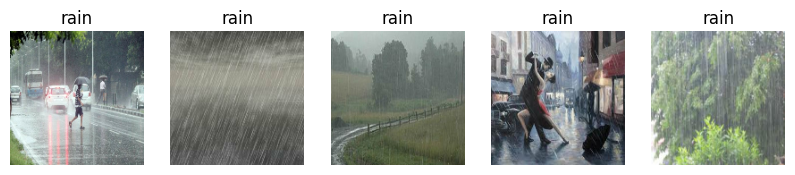

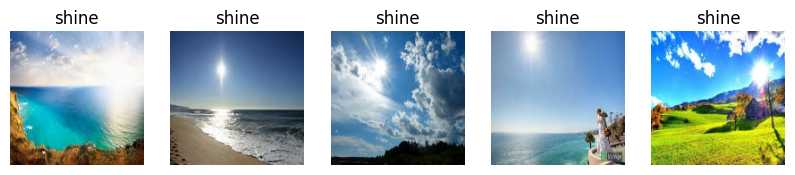

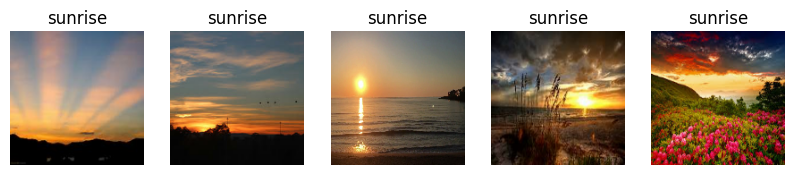

In [9]:
visualiza_imagenes()

### Creación y entrenamiento del Modelo

Ahora creamos el modelo con las espeficiaciones dadas:

- Capa **convolución** con 32 filtros, tamaño 3x3 y activación relu
- Capa de **pooling** tipo maxpooling de tamaño 2x2
- Capa **convolución** con 64 filtros, tamaño 3x3 y activación relu
- Capa de **pooling** tipo maxpooling de tamaño 2x2
- Capa **convolución** con 128 filtros, tamaño 3x3 y activación relu
- Capa de **pooling** tipo maxpooling de tamaño 2x2
- Capa para **aplanar** la información
- Capa de **dropout** al 0.3
- Capa **dénsamente conectada** de 128 neuronas y activación relu
- Capa de salida con **4  neuronas** y función de activación **softmax** ya que es un clasificación múltiple
- Se usará como Optimizador **rmsprop**


In [10]:
# Función para crear el modelo

def crea_modelo():
    # Capa de entrada formato 100x100 pixels y 3 canales de color RGB
    inputs = keras.Input(shape=(img_width, img_height, 3))
    
    # Dividimos entre 255 para "normalizar" el dato y dejarlo entre 0 7 1
    x = layers.Rescaling(1.0/255)(inputs)
    
    # Añadimos capa de convolución con 32 filtros de tamaño 3 y activación relu
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    # Añadimos capa de pooling, tipo max y de tamaño 2
    x = layers.MaxPooling2D(pool_size=2)(x)
    # Añadimos capa de convolución con 64 filtros de tamaño 3 y activación relu
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    # Añadimos capa de pooling, tipo max y de tamaño 2
    x = layers.MaxPooling2D(pool_size=2)(x)
    # Añadimos capa de convolución con 128 filtros de tamaño 3 y activación relu
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    # Añadimos capa de pooling, tipo max y de tamaño 2
    x = layers.MaxPooling2D(pool_size=2)(x)
    
    # Aplanamos los datos
    x = layers.Flatten()(x)
    
    # Regularización con Dropout al 0.3
    x = layers.Dropout(0.3)(x)
    
    
    # Ponemos una capa densamente conectada
    x = layers.Dense(128, activation="relu")(x)
    
    # La salida la hacemos de tipo softmax con 4 neuronas (números de clases diferentes)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    # Construimos el modelo de la Red Neuronal Convolucional
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    
    model.summary()
    return model

In [11]:
modelo = crea_modelo()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Definimos la función para realizar el entrenamiento del modelo, pasando como parámetro el **modelo** que se quiere entrenar así como las **épocas** (iteraciones) a realizar y los datos de **validación**.

In [12]:
# Función que entrena el modelo que le pasemos
# Le asignamos el flujo de entrada de entranamiento y validación
# Ponemos 10 iteraciones
def entrena_modelo(modelo,epocas):
  # Ejecutamos el entrenamiento
  # guardando el histórico de la
  # función de pérdida y la métrica
  history = modelo.fit(
    train_ds,
    epochs = epocas,
    validation_data = val_ds )
  return history

In [13]:
epocas = 20
historico = entrena_modelo(modelo,epocas)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 834ms/step - accuracy: 0.2947 - loss: 4.6165 - val_accuracy: 0.4311 - val_loss: 1.3283
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 756ms/step - accuracy: 0.4462 - loss: 1.2697 - val_accuracy: 0.3422 - val_loss: 1.2537
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 769ms/step - accuracy: 0.4638 - loss: 1.1737 - val_accuracy: 0.5556 - val_loss: 0.9000
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 790ms/step - accuracy: 0.6323 - loss: 0.8376 - val_accuracy: 0.5911 - val_loss: 0.8210
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 773ms/step - accuracy: 0.6307 - loss: 0.7576 - val_accuracy: 0.5556 - val_loss: 0.8302
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 796ms/step - accuracy: 0.6366 - loss: 0.7895 - val_accuracy: 0.4978 - val_loss: 0.9336
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 785ms/step - accuracy: 0.5440 - loss: 0.9147 - val_accuracy: 0.7378 - val_loss: 0.6993
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 752ms/step - accuracy: 0.7189 - loss: 0.7610 - val_accuracy: 0.5422 - val_loss:

Vemos cómo **evaluar el modelo** con unos datos concretos (en este caso los de validación) y ver la información de la **métrica** así como la **función de pérdida**, aplicado a un conjunto de datos. En este caso vemos que refleja la misma información que queda al final el entrenamiento con los datos de validación.

Se está alcanzando un **accuracy del 68%** con los datos de validación, que no está nada mal, para tener tan pocas iteraciones y habiendo tan pocas imágenes.

In [14]:
modelo.evaluate( val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6800 - loss: 1.0166


[1.0166218280792236, 0.6800000071525574]

Visualizamos el historico del entrenamiento del modelo para ver cómo es el comportamiento del entrenamiento.

In [15]:
# Mostramos las gráficas de histórico de entrenamiento
# de la función de pérdida y la métrica de entrenamiento y validación
def muestra_historico_entrenamiento(history, epocas):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(epocas)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


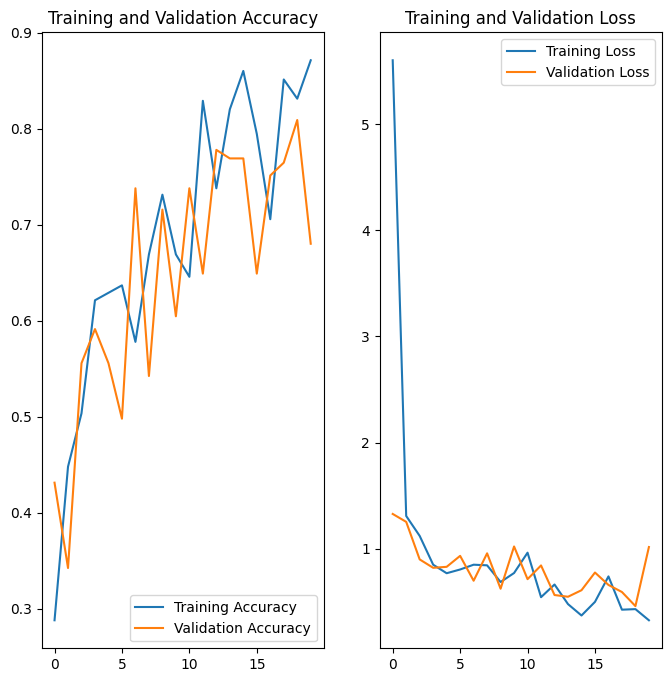

In [16]:
muestra_historico_entrenamiento(historico, epocas)

En las gráficas de evoluación del entrenamiento podemos ver que hay una tendencia a seguir mejorando, tanto en entrenamiento como en validación y que si pusiéramos más iteraciones seguramente se podría seguir mejorando.

Parece ser que tenemos una buena señal de que de momento no hay un sobreajuste en nuestro modelo.

### Matriz de Confusión del modelo

Mostramos la matriz de confusión para los datos de test del modelo entrenado.

Hay que tener mucho cuidado al crear la matriz de confusión si hemos usado la función `image_dataset_from_directory ` para obtener las imágenes, ya que por defecto se realiza un **barajado** cada vez que obtiene las imágenes (parámetro **shufle**). Esto significa que necesitamos sacar a la vez la información de las imágenes y de las etiquetas para que coincidan.

Para realizar esta tarea de sacar a la vez los datos (la imagen) y la etiqueta correspondiente iteraremos a través del objeto **val_ds** que nos devolverá un vector **images** y un vector **labels**. De esta manera tendremos emparejadas a la imágenes con sus etiquetas.

In [17]:
# Creamos la matriz de confusión con los datos de test
def matriz_confusion(modelo):
  global predicciones
  global val_labels
    
  for images, labels in val_ds:
    predicciones =  modelo.predict( images, verbose = 0 )
    val_labels = labels


  # Obtenemos las predicciones como Clasificación Multiclase
  predicciones = np.argmax(predicciones, axis=-1)
    
  # Obtenemos las predicciones como Clasificación Binaria
  # predicciones[predicciones <= 0.5] = 0
  # predicciones[predicciones > 0.5] = 1

  #Construimos el dataframe con la matriz de confusión de los valores reales y las predicciones
  df_cm = pd.DataFrame(confusion_matrix(predicciones,val_labels))
  df_cm.rename(columns={0: "cloudy", 1: "rain", 2:"shine", 3:"sunrise"},  inplace = True)
  df_cm.rename(index={0: "cloudy", 1: "rain", 2:"shine", 3:"sunrise"},  inplace = True)
  # Mostramos el gráfico de la matriz de confusión
  sn.set(font_scale=1.4) # for label size
  hm = sn.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"size": 16}) # font size
  hm.set(xlabel='Predicciones', ylabel='Real')
  plt.show()

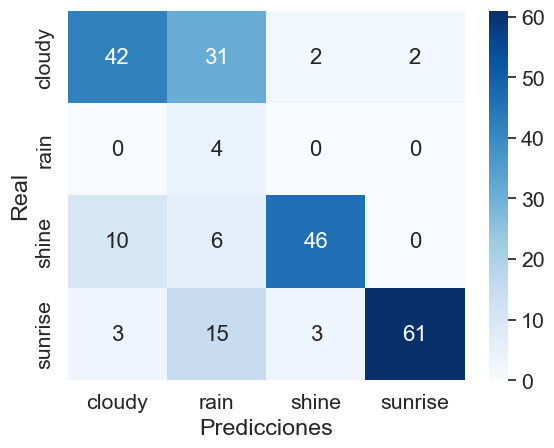

In [18]:

matriz_confusion(modelo)

Podemos ver a través de la matriz de confusión que corresponde con los datos obtenidos de la métrica de **Accuracy** (dividir el número de aciertos entre los totales) con la que obetenemos el porcentaje de aciertos sobre el total.

Además podemos comprobar como la clase **rain** es la que menos se acierta (sólo 4) confundiendo muchos con las clase **cloud** (31).

Tendríamos que ver si podemos hacer unas parametrizaciones distintas (más épocas, capas de convolución, número de filtros, regularización, data augmentation, etc,) para ver si podemos conseguir mejores resultados sobre las predicciones de esta clase.

### Visualización predicciones en test

In [19]:
# Función para visualizar imágenes aleatorias (5 de cada clase) de test
# Tenemos que poner el texto de la clase que se predice
def visualiza_imagenes_random_test(modelo):

  plt.figure(figsize=(10, 10))

  for images, labels in val_ds:
    predicciones =  modelo.predict( images, verbose = 0 )
    val_labels = labels

    # Obtenemos las predicciones como Clasificación Multiclase
    predicciones = np.argmax(predicciones, axis=-1)
      
    # Obtenemos las predicciones como Clasificación Binaria
    #predicciones[predicciones <= 0.5] = 0
    #predicciones[predicciones > 0.5] = 1
      
    predicciones = predicciones.astype(int)
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicciones[i]])
        plt.axis("off")

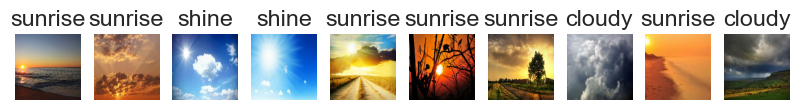

In [20]:
visualiza_imagenes_random_test(modelo)


## Ejercicio 5B

### Introducción

**Opción B - Clasificación de imágenes con redes pre-entrenadas**

Visto en el Ejercicio 3 nuestro trabajo para poder clasificar las imágenes meteorológicas,
proponemos en este apartado que se construya y entrene un modelo usando una red
preentrenada.

Se puede utilizar cualquiera de las **redes pre-entrenadas** que vienen con tensorflow/keras
(vgg16, vgg19, resnet101, etc)

Usaremos el **Feature Extraction**, quitando el top del modelo base y metiendo nuestra parte
final de clasificación para entrenarlo con nuestras imágenes.

Deberemos **entrenar el modelo** con nuestras imágenes y **visualizar 10 imágenes** de test,
poniendo como **título la predicción** que nos salga con nuestro modelo.

**Compara** este modelo a nivel de la métrica que hayas definido, en validación con lo que se
obtiene en el Ejercicio 3.

### Información de versiones e Importación de funciones propias

Presentamos información de las versiones usadas de Python y tensorflow, además definir todas las funciones que luego usamos para no estar escribiendo todo el rato el mismo código.

In [21]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

import tensorflow as tf
print("Tensorflow version")
print(tf.__version__)

Python version
3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:04:44) [MSC v.1940 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=12, micro=4, releaselevel='final', serial=0)
Tensorflow version
2.17.0


In [22]:
import os
import matplotlib.pyplot as plt
#from matplotlib.image import imread
#import random
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras import utils
#from tensorflow.keras.utils import img_to_array
from tensorflow.keras import applications
#from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sn
import pandas as pd
#import matplotlib.pyplot as plt

### Definimos las funciones y preparmos las imágenes

In [23]:
# Función para descargar el dataset y descomprimirlo
def carga_dataset():
    global train_dir
    global test_dir
    import pathlib
    dataset_url = "https://www.dropbox.com/scl/fi/hzlgwcfavzqmhpylkzuw7/weather.zip?rlkey=m440ako3hlavp8b6jyu0skti9&st=mt7bv32e&dl=1"
    # Descargamos el fichero con todas las imágenes y 
    # lo desempaquetamos
    global data_dir
    data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   extract=True)

    data_dir = os.path.dirname(data_dir)

    # Definimos los directorios para usar
    data_dir = data_dir + "\\weather"
    print(data_dir)

# Creamos los generadores de imágenes
# Nos van a permitir leer la imágenes desde los directorios
def crea_generadores_imagenes():
    global train_ds
    global val_ds
    global class_names
    global num_classes
    global ficheros_train_pizza
    global ficheros_train_not_pizza
    global ficheros_test_pizza
    global ficheros_test_not_pizza

    train_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    # Definimos 
    val_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    class_names = train_ds.class_names
    print(class_names)

 
    num_classes = 4

# Función para visualizar imágenes aleatorias (5 de cada clase) de entrenamiento
def visualiza_imagenes():

    # Mostramos los elementos de la clase 0 ( cloudy )
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.map(lambda x, y:  (x[y==0], y[y==0])): # Nos quedamos sólo con los datos de la clase 0
      for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("cloudy")
        plt.axis("off")
          
    # Mostramos los elementos de la clase 1 ( rain )
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.map(lambda x, y:  (x[y==1], y[y==1])):  # Nos quedamos sólo con los datos de la clase 1
      for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("rain")
        plt.axis("off")

    # Mostramos los elementos de la clase 2 ( shine )
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.map(lambda x, y:  (x[y==2], y[y==2])): # Nos quedamos sólo con los datos de la clase 2
      for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("shine")
        plt.axis("off")
          
    # Mostramos los elementos de la clase 3 ( sunrise )
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.map(lambda x, y:  (x[y==3], y[y==3])):  # Nos quedamos sólo con los datos de la clase 3
      for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("sunrise")
        plt.axis("off")


C:\Users\acca3\.keras\datasets\weather
Found 1125 files belonging to 4 classes.
Using 900 files for training.
Found 1125 files belonging to 4 classes.
Using 225 files for validation.
['cloudy', 'rain', 'shine', 'sunrise']


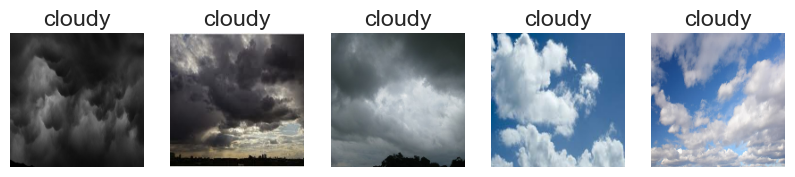

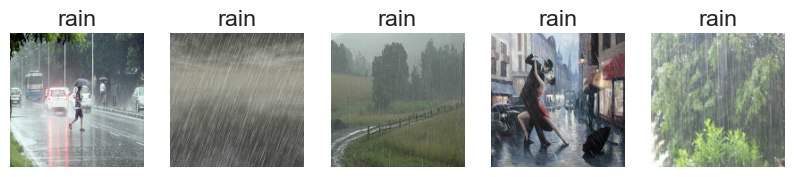

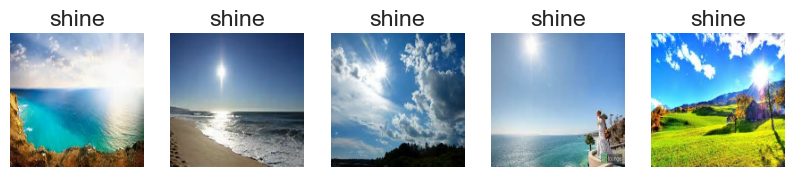

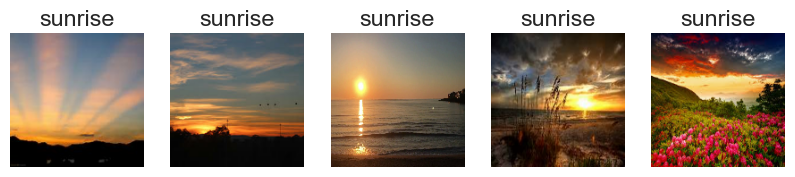

In [24]:
# Definimos el tamaño del batch
# Definimos el tamaño de imagen con la que queremos trabajar
batch_size = 256
img_height = 150
img_width = 150

carga_dataset()
crea_generadores_imagenes()
visualiza_imagenes()

### Creación y entrenamiento del Modelo

Para usar una red preentrenada haciendo el **Feature Extraction**, tendremos que coger el modelo de la red preentrenada que queramos usar, y quitarle la parte final, ésto lo haremos cuando creemos el modelo base con la opción **include_top=False**. De esta manera tendremos todas las capas previas que han sido entrenadas con millones de imágenes, y que no hará falta entrenar, pero nosotros le añadiremos la parte final para que aprenda a categorizar las imágenes de nuestro dataset.

En este modelo vamos a tener:

- Modelo base **VGG16**
- Capa para **aplanar** la información
- Capa de **dropout** al 0.3
- Capa **dénsamente conectada** de 256 neuronas y activación relu
- Capa **dénsamente conectada** de 64 neuronas y activación relu
- Capa de **salida de** 1 neurona y activación **sigmoid** que nos da la clasificación binaria

Deberemos tener en cuenta que al hacer el **Feature Extraction** no tendremos que incluir la parte **top** de la red preentrenada que vayamos a usar, y además tendremos que marcar como **no entrenable** toda esta parte. De esta forma todos los **pesos** de la red preentrenada no se entrenarán, y sólo se entrenará la parte final de nuestra red neuronal. Es decir, nos aprovecharemos de todas esas características que la red preentranada ya ha aprendido, para entrenar la última parte, la categoriza, con nuestras imágenes.

In [25]:
# Función para la creación del modelo 3
def crea_modelo_red_preentrenada():
    # Creamos el modelo
    # Capa de entrada formato 180x180 pixels y 3 canales de color RGB
    inputs = keras.Input(shape=(img_width, img_height, 3))
    
    # Dividimos entre 255 para "normalizar" el dato y dejarlo entre 0 7 1
    x = layers.Rescaling(1./255)(inputs)

    # Cargamos el modelo pre-entrenado de la red VGG16
    base_model = applications.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(img_width, img_height, 3))  # No cargamos la parte de clasificación sólo las Feature Extraction
    
    # Bloqueamos para que no se entrenen estos parámetros
    base_model.trainable = False

    x = base_model(x)
    
   # Aplanamos los datos
    x = layers.Flatten()(x)
    
    # Regularización con Dropout al 0.3
    x = layers.Dropout(0.3)(x)
    
    
    # Ponemos una capa densamente conectada
    x = layers.Dense(128, activation="relu")(x)
    
    # La salida la hacemos de tipo softmax con 4 neuronas (números de clases diferentes)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    # Construimos el modelo de la Red Neuronal Convolucional
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    
    model.summary()
    return model


In [26]:
modelo_red_preentrenada = crea_modelo_red_preentrenada()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 1,049,220 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Podemos observar cómo la red tiene **15.763.908** parámetros de los cuales sólo vamos a entrenar **1.049.220**, ya que el resto ya están previamente entrenados.

In [27]:
# Función que entrena el modelo que le pasemos
# Le asignamos el flujo de entrada de entranamiento y validación
# Ponemos 10 iteraciones
def entrena_modelo(modelo,epocas):
  # Ejecutamos el entrenamiento
  # guardando el histórico de la
  # función de pérdida y la métrica
  history = modelo.fit(
    train_ds,
    epochs = epocas,
    validation_data = val_ds )
  return history

In [28]:
epocas = 20
historico_red_preentrenada = entrena_modelo(modelo_red_preentrenada,epocas)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.2591 - loss: 4.7354 - val_accuracy: 0.4133 - val_loss: 2.2006
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - accuracy: 0.4856 - loss: 1.6320 - val_accuracy: 0.6489 - val_loss: 0.8436
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step - accuracy: 0.7494 - loss: 0.6709 - val_accuracy: 0.7556 - val_loss: 0.6391
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - accuracy: 0.8303 - loss: 0.5047 - val_accuracy: 0.7867 - val_loss: 0.6391
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 13s/step - accuracy: 0.8509 - loss: 0.4604 - val_accuracy: 0.7511 - val_loss: 0.6619
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 12s/step - accuracy: 0.7569 - loss: 0.5785 - val_accuracy: 0.8311 - val_loss: 0.5025
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step - accuracy: 0.9004 - loss: 0.3454 - val_accuracy: 0.7422 - val_loss: 0.8592
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step - accuracy: 0.7160 - loss: 0.8217 - val_accuracy: 0.8267 - val_loss: 0.4570
Ep

Visualizamos la evolución del entrenamiento

In [29]:
# Mostramos las gráficas de histórico de entrenamiento
# de la función de pérdida y la métrica de entrenamiento y validación
def muestra_historico_entrenamiento(history, epocas):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(epocas)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


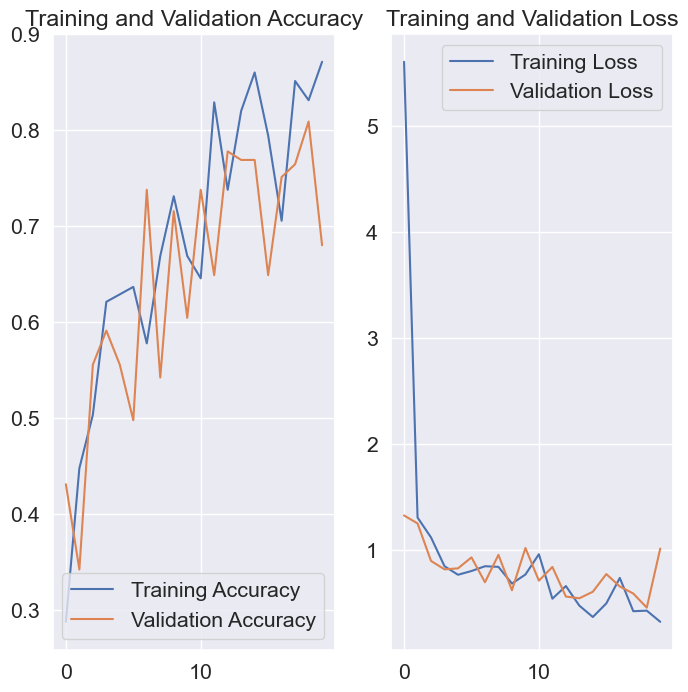

In [30]:
muestra_historico_entrenamiento(historico, epocas)

### Visualizamos 10 imágenes con sus predicciones

In [31]:
# Función para visualizar imágenes aleatorias (5 de cada clase) de test
# Tenemos que poner el texto de la clase que se predice
def visualiza_imagenes_random_test(modelo):

  plt.figure(figsize=(10, 10))

  for images, labels in val_ds:
    predicciones =  modelo.predict( images, verbose = 0 )
    val_labels = labels

    # Obtenemos las predicciones como Clasificación Multiclase
    predicciones = np.argmax(predicciones, axis=-1)
      
    # Obtenemos las predicciones como Clasificación Binaria
    #predicciones[predicciones <= 0.5] = 0
    #predicciones[predicciones > 0.5] = 1
      
    predicciones = predicciones.astype(int)
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicciones[i]])
        plt.axis("off")

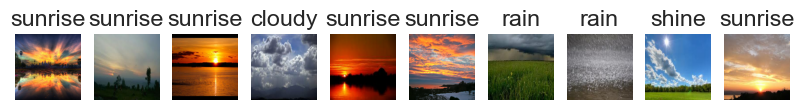

In [32]:
visualiza_imagenes_random_test(modelo_red_preentrenada)

### Comparamos los modelos

In [33]:
modelo.evaluate(val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6800 - loss: 1.0166


[1.0166218280792236, 0.6800000071525574]

In [34]:
modelo_red_preentrenada.evaluate(val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.8444 - loss: 0.4108


[0.4108433723449707, 0.8444444537162781]

Podemos observar como con la **red preentrenada** conseguimos un mejor valor para **accuracy** en los datos de test llegando al **84,4%**, además de haber podido observar como la evolución del entrenamiento permitía haber seguido entrenando el modelo con más iteraciones sin llegar a un **sobreajuste**.

Está claro que la red preentrenada nos ha ayudado a mejor nuestro modelo de red neuronal y conseguir una mejor precisión en nuestras predicciones.